In [80]:
import sys
sys.path.insert(0,'..')

from src.models import *
from src.loss_functions import *
from src.noise import *
from src.metrics import *
from src.plotting import *
from src.generate_data import *
from src.real_data import *

import sklearn
import pandas as pd

from scipy.stats import bernoulli

from operator import xor

import os


In [81]:
# for dataset in ["cshock_eicu", "cshock_mimic", "saps", "support", "lungcancer"]:

#     X_train, X_test, y_train, y_test, group_train, group_test = load_dataset_splits(dataset, group="age")
#     print(dataset)
#     print("n", X_train.shape[0] + X_test.shape[0])
#     print("d", X_train.shape[1] + X_test.shape[1])


In [82]:
def load_abstain(dataset, model_type, noise_type, epsilon=0.1, fixed_class = 0, fixed_noise = 0.0, misspecify = "correct"):
    path = "/scratch/hdd001/home/snagaraj/results/abstain/"
    
    file_path = os.path.join(path, dataset, model_type, noise_type, misspecify ,f"{epsilon}.pkl")
    
    with open(file_path, 'rb') as file:
            # Use pickle to write the dictionary to the file
            data = pkl.load(file)
            
    return data
    

In [83]:
pd.DataFrame(load_abstain("cshock_mimic", "LR", "class_independent", misspecify="correct"))

,noise,loss,disagreement_test,ambiguity_train,ambiguity_test,disagreement_train,test_probs,train_probs,draw_id
0,0.01,BCE,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 60.0, 0.0, 100.0, 4.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 96.96969696969697, 0.0, 0.0, 15.51515151...","[[0.03940906811755829, 0.9605909318824417], [0...","[[0.16209387126848585, 0.8379061287315142], [0...",0
1,0.01,backward,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 60.0, 0.0, 100.0, 4.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 96.96969696969697, 0.0, 0.0, 15.51515151...","[0.96393424, 0.6031643, 0.744092, 0.04056909, ...","[0.84035724, 0.46518967, 0.18155473, 0.7976285...",0
2,0.01,forward,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 60.0, 0.0, 100.0, 4.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 96.96969696969697, 0.0, 0.0, 15.51515151...","[0.9644586, 0.6049211, 0.74891824, 0.039932467...","[0.84829676, 0.46865398, 0.17713685, 0.7991478...",0
3,0.01,BCE,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 41.0, 0.0, 100.0, 1.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 97.73737373737373, 0.0, 0.0, 4.0, 0.0, 0...","[[0.03856267224069987, 0.9614373277593001], [0...","[[0.16905397493850294, 0.8309460250614971], [0...",1
4,0.01,backward,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 41.0, 0.0, 100.0, 1.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 97.73737373737373, 0.0, 0.0, 4.0, 0.0, 0...","[0.9653553, 0.59433126, 0.75174004, 0.04021103...","[0.8462166, 0.47147897, 0.18700933, 0.7921524,...",1
5,0.01,forward,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 41.0, 0.0, 100.0, 1.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 97.73737373737373, 0.0, 0.0, 4.0, 0.0, 0...","[0.9655723, 0.593792, 0.75555885, 0.039443858,...","[0.851506, 0.47724748, 0.18381126, 0.7921776, ...",1
6,0.01,BCE,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 100.0, 0.0, 100.0, 78.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 69.33333333333334, 0.0, 0...","[[0.03870914849800844, 0.9612908515019916], [0...","[[0.17225264106471938, 0.8277473589352806], [0...",2
7,0.01,backward,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 100.0, 0.0, 100.0, 78.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 69.33333333333334, 0.0, 0...","[0.96364313, 0.6086043, 0.7639595, 0.03517965,...","[0.8454397, 0.43281624, 0.18554595, 0.7883552,...",2
8,0.01,forward,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 100.0, 0.0, 100.0, 78.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 69.33333333333334, 0.0, 0...","[0.9648851, 0.6041061, 0.7659524, 0.035073176,...","[0.84993905, 0.43744394, 0.1811805, 0.7892337,...",2
9,0.01,BCE,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 95.0, 0.0, 100.0, 28.000000000000004, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 19.191919191919194, 0.0, 0.0, 81.4545454...","[[0.039614465711152125, 0.9603855342888479], [...","[[0.16925034476457834, 0.8307496552354217], [0...",3


In [84]:
regrets = []
risks_train = []
risks_test = []
coverages = []
thresholds = []
fprs = []
fnrs = []
noise_levels = []
losses = []
datasets = []
draw_ids = []
methods = []

noise_type = "class_conditional"
fixed_class = 0
fixed_noise = 0.0
misspecify = "correct"
model_type = "LR"

for dataset in ["cshock_mimic"]:
#for dataset in ["cshock_eicu"]:
    X_train, X_test, y_train, y_test, group_train, group_test = load_dataset_splits(dataset, group="age")

    y_train = y_train.astype(int)
    y_test = y_test.astype(int)

    data = load_abstain(dataset, model_type, noise_type, misspecify=misspecify)

    df = pd.DataFrame(data)

    for noise_level in df.noise.unique():
        
        if noise_type == "class_independent":
            _, T = generate_class_independent_noise(y_train, noise_level)
        else: 
            _, T = generate_class_conditional_noise(y_train, noise_level, fixed_class, fixed_noise)

        
        for loss in df.loss.unique():
            
            for draw_id in [0,1,2,3,4]:
                u_vec = get_u(y_train, T=T, seed=draw_id, noise_type=noise_type)
                yn_train = flip_labels(y_train, u_vec)  # XOR
                
                sub_df = df[(df["loss"] == loss) & (df["noise"] == noise_level) & (df["draw_id"] == draw_id)]

                amb_test = sub_df.ambiguity_test.values[0]/100
                amb_test = np.clip(amb_test, 0,1)
            
                amb_train = sub_df.ambiguity_train.values[0]/100
                amb_train = np.clip(amb_train, 0,1)
            
                train_probs = (sub_df.train_probs.values[0] )
                test_probs = (sub_df.test_probs.values[0] )
            
                
                if train_probs.ndim == 2:
                    train_preds = np.argmax(train_probs, axis=1)
                    test_preds = np.argmax(test_probs, axis=1)
                    train_confidence = np.max(train_probs, axis=1)
                    test_confidence = np.max(test_probs, axis=1)
                
                    
                else:
                    train_preds = (train_probs>0.5).astype(int)
                    test_preds = (test_probs>0.5).astype(int)
                    
                    train_confidence = np.where(train_probs > 0.5, train_probs, 1 - train_probs)
                    test_confidence = np.where(test_probs > 0.5, test_probs, 1 - test_probs)

                for method in ["confidence", "ambiguity"]:
                    for threshold in np.linspace(0, 1, 100):  ##

                        err_anticipated_train = abs(train_preds - yn_train)
                        err_true_train = abs(train_preds - y_train)
                        
                        if method == "confidence":
                            abstain_train = abstain(train_confidence, threshold)
                            abstain_test = abstain(test_confidence, threshold)
                        else:
                            abstain_train = abstain(amb_train, threshold)
                            abstain_test = abstain(amb_test, threshold)

                        clean_risk_train = 100 * np.mean(abs(train_preds - y_train) * (1 - abstain_train))
                        clean_risk_test = 100 * np.mean(abs(test_preds - y_test) * (1 - abstain_test))

                        regret_train = 100 * np.mean(abs(err_anticipated_train - err_true_train) * (1 - abstain_train))

                        coverage_train = 100 * np.mean(1 - abstain_train)

                        # Calculate False Positives (FP) and False Negatives (FN)

                        err_true = err_true_train * (1 - abstain_train)
                        err_anticipated = err_anticipated_train * (1 - abstain_train)

                        false_positives = np.where((err_anticipated == 1) & (err_true == 0))[0]
                        false_negatives = np.where((err_anticipated == 0) & (err_true == 1))[0]

                        # Calculate the number of true negatives and true positives
                        true_negatives = np.sum(1 - err_true)
                        true_positives = np.sum(err_true)

                        # Calculate the rates with checks for division by zero
                        fp_rate = len(false_positives) / true_negatives if true_negatives > 0 else 0
                        fn_rate = len(false_negatives) / true_positives if true_positives > 0 else 0

                        # Append metrics and values
                        regrets.append(regret_train)
                        risks_train.append(clean_risk_train)
                        risks_test.append(clean_risk_test)
                        coverages.append(100-coverage_train)
                        fprs.append(fp_rate)
                        fnrs.append(fn_rate)
                        thresholds.append(threshold)
                        noise_levels.append(noise_level)
                        losses.append(loss)
                        datasets.append(dataset)
                        draw_ids.append(draw_id)
                        methods.append(method)
                        
                    # Append metrics and values
                    regrets.append(0)
                    risks_train.append(0)
                    risks_test.append(0)
                    coverages.append(100-0)
                    fprs.append(0)
                    fnrs.append(0)
                    thresholds.append(100)
                    noise_levels.append(noise_level)
                    losses.append(loss)
                    datasets.append(dataset)
                    draw_ids.append(draw_id)
                    methods.append(method)

# Create a DataFrame from the arrays
data = pd.DataFrame({
    'Regret': regrets,
    'Risk_Train': risks_train,
    'Risk_Test': risks_test,
    'Coverage': coverages,
    "FPR": fprs,
    "FNR":fnrs,
    'Threshold': thresholds,
    'Noise Level': noise_levels,
    'Loss': losses,
    'Dataset': datasets,
    'Draw_id': draw_ids,
    "Method": methods
})

# # Save the DataFrame to a CSV file
# data.to_csv('output.csv', index=False)

# print("DataFrame saved to 'output.csv'")


In [85]:
data

,Regret,Risk_Train,Risk_Test,Coverage,FPR,FNR,Threshold,Noise Level,Loss,Dataset,Draw_id,Method
0,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.01,BCE,cshock_mimic,0,confidence
1,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.010101,0.01,BCE,cshock_mimic,0,confidence
2,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.020202,0.01,BCE,cshock_mimic,0,confidence
3,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.030303,0.01,BCE,cshock_mimic,0,confidence
4,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.040404,0.01,BCE,cshock_mimic,0,confidence
...,...,...,...,...,...,...,...,...,...,...,...,...
12115,6.981890,11.013685,9.046214,22.322380,0.035823,0.344494,0.969697,0.40,forward,cshock_mimic,4,ambiguity
12116,7.301483,11.546341,9.537856,21.470130,0.039652,0.328602,0.979798,0.40,forward,cshock_mimic,4,ambiguity
12117,7.506351,12.275670,10.095051,20.535934,0.042317,0.309079,0.989899,0.40,forward,cshock_mimic,4,ambiguity
12118,19.798410,20.519544,19.698460,0.000000,0.201361,0.184904,1.000000,0.40,forward,cshock_mimic,4,ambiguity


/tmp/ipykernel_955/4265562663.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_data = sub_data.groupby(['Coverage_Binned', 'Method']).agg({
/tmp/ipykernel_955/4265562663.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(int(x)) + '%' if x == 100 else str(int(x)) for x in ax.get_xticks()])
/tmp/ipykernel_955/4265562663.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(int(y)) + '%' if y == 20.0 else str(int(y)) for y in ax.get_yticks()])


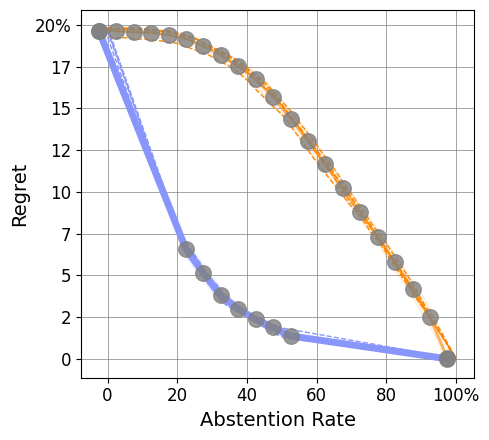

In [108]:
# Define your custom color palette for each method
method_colors = {
    "ambiguity": "#8896FB",   # Custom color for Ambiguity method
    "confidence": "#fc8803"  # Custom color for Confidence method
}

# Set the font style to sans-serif
plt.rcParams["font.family"] = "sans-serif"

# Define bins for coverage
bins = np.arange(-20, 110, 5)  # Bins from 0 to 100 with a width of 5
labels = (bins[:-1] + bins[1:]) / 2  # Labels for the bins, midpoints

# List of noise levels to plot
noise_levels_to_plot = [0.4]

for noise_level in noise_levels_to_plot:
    fig, ax = plt.subplots(figsize=(5, 5))  # Create a new figure
    
    sub_data = data[data["Loss"] == "BCE"]
    sub_data = sub_data[sub_data["Noise Level"] == noise_level]

    # Bin the coverage values
    sub_data['Coverage_Binned'] = pd.cut(sub_data['Coverage'], bins=bins, labels=labels, include_lowest=True)

    # Plot each draw ID separately with dashed lines (raw data)
    for draw_id in sub_data['Draw_id'].unique():
        draw_data = sub_data[sub_data['Draw_id'] == draw_id]
        
        for method in draw_data['Method'].unique():
            method_data = draw_data[draw_data['Method'] == method]
            color = method_colors.get(method, "#808080")
            sns.lineplot(data=method_data, x='Coverage', y='Regret', ax=ax, 
                         linewidth=1, color=color, linestyle='--', label=None)

    # Calculate mean and std deviation for each bin and method for the average plot
    mean_data = sub_data.groupby(['Coverage_Binned', 'Method']).agg({
        'Regret': ['mean', 'std']
    }).reset_index()
    mean_data.columns = ['Coverage_Binned', 'Method', 'Regret_mean', 'Regret_std']

    # Plot the averaged line with solid line
    for method in mean_data['Method'].unique():
        method_data = mean_data[mean_data['Method'] == method]
        line_width = 5 if method == "ambiguity" else 2
        alpha = 1 if method == "ambiguity" else 0.6
        color = method_colors.get(method, "#808080")
        
        # Line plot with fill between for standard deviation
        sns.lineplot(data=method_data, x='Coverage_Binned', y='Regret_mean', ax=ax, 
                     linewidth=line_width, color=color, label=method, alpha=alpha)
        
        ax.fill_between(method_data['Coverage_Binned'], 
                        method_data['Regret_mean'] - method_data['Regret_std'], 
                        method_data['Regret_mean'] + method_data['Regret_std'], 
                        alpha=0.1, color=color)
        
        # Scatter points at each knot with higher zorder to ensure they appear on top
        plt.scatter(method_data['Coverage_Binned'], method_data['Regret_mean'], color="gray", s=125, zorder=5, alpha=0.8)

    # Adjust the x and y axis ticks to be rounded
    ax.set_xticklabels([str(int(x)) + '%' if x == 100 else str(int(x)) for x in ax.get_xticks()])
    ax.set_yticklabels([str(int(y)) + '%' if y == 20.0 else str(int(y)) for y in ax.get_yticks()])
    
    ax.set_xlabel("Abstention Rate", fontsize=14)
    ax.set_ylabel("Regret", fontsize=14)
    
    num_x_ticks = 5
    num_y_ticks = 5
    
    #ax.set_xlim(0, 100)
    #ax.set_ylim(0, 25)

    
    #ax.set_xticks(np.linspace(0, 100, num_x_ticks))
    #ax.set_yticks(np.linspace(0, 20, num_y_ticks))
    
    # Set grey gridlines
    ax.grid(True, which='both', color='grey', linestyle='-', linewidth=0.5)
    
    # Customize major and minor ticks and their labels
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)

    # Remove the legend
    ax.get_legend().remove()
    
    # Adjust layout to make space for the legend
    plt.tight_layout(rect=[0, 0.1, 1, 1])
    
    # Save the plot
    plt.savefig("abstain.pdf", bbox_inches='tight')
    plt.show()


/tmp/ipykernel_955/1956547337.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_data = sub_data.groupby(['Coverage_Binned', 'Method']).agg({
/tmp/ipykernel_955/1956547337.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(int(x)) + '%' if x == 100 else str(int(x)) for x in ax.get_xticks()])
/tmp/ipykernel_955/1956547337.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(int(y)) + '%' if y == 25 else str(int(y))+"  " for y in ax.get_yticks()])


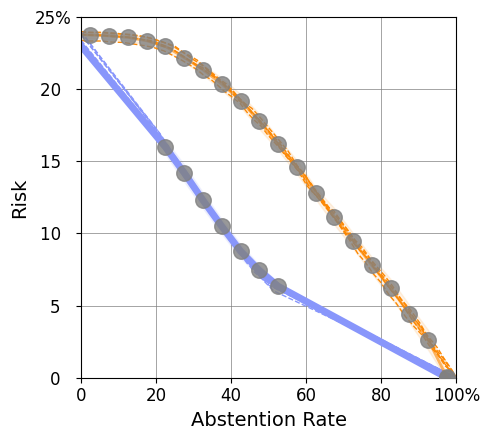

In [87]:
# Define your custom color palette for each method
method_colors = {
    "ambiguity": "#8896FB",   # Custom color for Ambiguity method
    "confidence": "#fc8803"  # Custom color for Confidence method
}


# Define bins for coverage
bins = np.arange(-20, 110,5)  # Bins from 0 to 120 with a width of 2
labels = (bins[:-1] + bins[1:]) / 2  # Labels for the bins, midpoints

# List of noise levels to plot
noise_levels_to_plot = [0.4]

for noise_level in noise_levels_to_plot:
    fig, ax = plt.subplots(figsize=(5, 5))  # Create a new figure
    
    sub_data = data[data["Loss"] == "BCE"]
    sub_data = sub_data[sub_data["Noise Level"] == noise_level]

    # Bin the coverage values
    sub_data['Coverage_Binned'] = pd.cut(sub_data['Coverage'], bins=bins, labels=labels, include_lowest=True)

    # Plot each draw ID separately with dashed lines (raw data)
    for draw_id in sub_data['Draw_id'].unique():
        draw_data = sub_data[sub_data['Draw_id'] == draw_id]
        
        for method in draw_data['Method'].unique():
            method_data = draw_data[draw_data['Method'] == method]
            color = method_colors.get(method, "#808080")
            sns.lineplot(data=method_data, x='Coverage', y='Risk_Train', ax=ax, 
                         linewidth=1, color=color, linestyle='--', label=None)

    # Calculate mean and std deviation for each bin and method for the average plot
    mean_data = sub_data.groupby(['Coverage_Binned', 'Method']).agg({
        'Risk_Train': ['mean', 'std']
    }).reset_index()
    mean_data.columns = ['Coverage_Binned', 'Method', 'Risk_mean', 'Risk_std']

    # Plot the averaged line with solid line
    for method in mean_data['Method'].unique():
        method_data = mean_data[mean_data['Method'] == method]
        line_width = 5 if method == "ambiguity" else 2
        alpha = 1 if method == "ambiguity" else 0.6
        color = method_colors.get(method, "#808080")
        
        # Line plot with fill between for standard deviation
        sns.lineplot(data=method_data, x='Coverage_Binned', y='Risk_mean', ax=ax, 
                     linewidth=line_width, color=color, label=method, alpha=alpha)
        
        ax.fill_between(method_data['Coverage_Binned'], 
                        method_data['Risk_mean'] - method_data['Risk_std'], 
                        method_data['Risk_mean'] + method_data['Risk_std'], 
                        alpha=0.1, color=color)
        
        # Scatter points at each knot with higher zorder to ensure they appear on top
        plt.scatter(method_data['Coverage_Binned'], method_data['Risk_mean'], color="gray", s=125, zorder=5, alpha = 0.8)

    ax.set_xlim(0, 100)
    ax.set_ylim(0, 35)
    ax.set_xlabel("Abstention Rate", fontsize=14)
    ax.set_ylabel("Risk", fontsize=14)
    ax.set_xticklabels([str(int(x)) + '%' if x == 100 else str(int(x)) for x in ax.get_xticks()])
    ax.set_yticklabels([str(int(y)) + '%' if y == 25 else str(int(y))+"  " for y in ax.get_yticks()])
        #ax.set_title('FPR and Coverage vs. Shift', size=16)
    # Set the number of ticks on the x and y axes
    num_x_ticks = 6
    num_y_ticks = 6

    ax.set_xticks(np.linspace(0, 100, num_x_ticks))
    ax.set_yticks(np.linspace(0, 35, num_y_ticks))
    # Set grey gridlines
    ax.grid(True, which='both', color='grey', linestyle='-', linewidth=0.5)
    
    # Customize major and minor ticks and their labels
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=10)

    # Remove the legend
    ax.get_legend().remove()
    
    # Adjust layout to make space for the legend
    plt.tight_layout(rect=[0, 0.1, 1, 1])
    
    # Save the plot
    plt.savefig("abstain_risk.pdf", bbox_inches='tight')
    plt.show()
